In [155]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

Remember that in week 1 we had generated open-loop commands for a set of manoeuvres such as
$[("straight", 5), ("right", 90), ("straight", 6), ("left", 90)]$

Let us do repeat, but with a change. Instead of left/ right, simply use turn and a signed angle.
$[("straight", 5), ("turn", -90), ("straight", 6), ("turn", 90)]$

You can use cubic_spiral() from previous notebook

In [156]:
num_sts_pts=10
num_turn_pts=50
v=0.333 #with this value we are able to take turn of 1m radius
#v=0.166  #with this value we are able to take turn of 0.5m radius
def cubic_spiral(theta_i, theta_f, n=10):
  x = np.linspace(0, 1, num=n)
  #-2*x**3 + 3*x**2
  return (theta_f-theta_i)*(-2*x**3 + 3*x**2) + theta_i
    
def straight(dist,curr_pose):
    # the straight-line may be along x or y axis
    #curr_theta will determine the orientation
    v=0.333
    xc,yc,thetac=curr_pose
    dt=0.01
    x,y,t=np.array([]),np.array([]),np.array([])
    x=np.append(x,xc)
    y=np.append(y,yc)
    t=np.append(t,thetac)
    while abs(x[-1]-xc) < dist and abs(y[-1]-yc) < dist:
      x=np.append(x,x[-1]+v*np.cos(thetac)*dt)
      y=np.append(y,y[-1]+v*np.sin(thetac)*dt)
      t=np.append(t,thetac)
    return x,y,t

def turn(change, curr_pose):
    # adjust scaling constant for desired turn radius
    dt=0.1
    xc,yc,thetac=curr_pose
    theta_i=thetac
    theta_f=thetac+np.deg2rad(change)
    theta=cubic_spiral(theta_i,theta_f,num_turn_pts)
    x = xc+np.cumsum(v*np.cos(theta)*dt)
    y = yc+np.cumsum(v*np.sin(theta)*dt)
    theta=np.array(theta)
    #print(x,y)
    return x,y,theta

def generate_trajectory(route,init_pose = (0, 0,np.pi/2)):
  func={'straight':straight,'turn':turn}
  x,y,t=np.array([]),np.array([]),np.array([])
  x=np.append(x,init_pose[0])
  y=np.append(y,init_pose[1])
  t=np.append(t,init_pose[2])
  for manoeuvre,command in route:
    px,py,pt=func[manoeuvre](command,[x[-1],y[-1],t[-1]])
    #update x,y,t using np.concatenate and px,py,pt
    x=np.concatenate([x,px])
    y=np.concatenate([y,py])
    t=np.concatenate([t,pt])
  return x,y,t


    

### Plot the trajectory
plot the trajectory and the change in orientation in separate plots

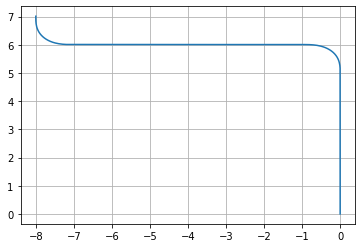

In [157]:
x,y,t=generate_trajectory([("straight",5),("turn",90),("straight",6),("turn",-90)])
plt.figure()
#plt.axes().set_aspect("equal","datalim")
plt.plot(x,y)
plt.grid()



## Convert 

A* or Djikstra gives a sequence of $\{(x_i, y_i)\}$. We need to convert it to a sequence of {"straight", "turn"} if we are use generate_trajectory()

Let us look at a simple method. Assume that the successive line segments are orthogonal (reasonable in the grid world). If we find the corner point, we can demarcate. 

For 3 consecutive points $(x_1,y_1), (x_2, y_2), (x_3, y_3)$ if 
$(x_1 - x_2)(y_3-y2) - (x_3-x_2)(y_2-y_1) \neq 0$, then $(x_2, y_2)$ is a corner point

Think about what is happening if

1. $(x_1 - x_2)(y_3-y2) - (x_3-x_2)(y_2-y_1) > 0$

2. $(x_1 - x_2)(y_3-y2) - (x_3-x_2)(y_2-y_1) < 0$

[[0, 5]]
[['straight', 4.0], ['turn', -90], ['straight', 4.0]]


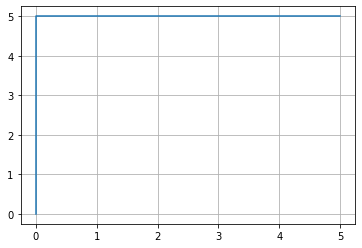

In [158]:
# here is a code to generate 2 orthogonal 
# line segments of lengths 6
s1,s2=6,6
y1=list(range(s1))
x1=[0]*s1

x2=list(range(s2))
y2=[y1[-1]]*s2
x,y=x1[:-1]+x2,y1[:-1]+y2
plt.figure()
plt.plot(x,y)
plt.grid()


corner_point=[]
#find the corner point and plot it
for x1,x2,x3,y1,y2,y3 in zip(x[:-2],x[1:-1],x[2:],y[:-2],y[1:-1],y[2:]):
  slope=(x1-x2)*(y3-y2)-(x3-x2)*(y2-y1)
  if slope!=0:
    corner_point.append([x2,y2])
print(corner_point)

def euclidean(node1, node2):
  x1, y1 = node1
  x2, y2 = node2
  return np.sqrt((x1-x2)**2+(y1-y2)**2)
  
def segment_to_route(initial_pose,final_pose,corner_point,turn_radius):
   route=[["straight",0],["turn",0],["straight",0]]
   segment=[]
   segment.append(euclidean(initial_pose,corner_point)-turn_radius)
   segment.append(euclidean(corner_point,final_pose)-turn_radius)
   route[0][1]=segment[0]
   route[2][1]=segment[1]
   x1,y1,x2,y2,x3,y3=initial_pose[0],initial_pose[1],corner_point[0],corner_point[1],final_pose[0],final_pose[1]
   if y2-y1==0:
     if x2-x1>0:
       slope1=0
     else:
       slope1=180
   elif y2-y1>0:
     slope1=90
   else:
     slope1=-90
   if y3-y2==0:
     if x3-x2>0:
       slope2=0
     else:
       slope2=180
   elif y3-y2>0:
     slope2=90
   else:
     slope2=-90
   diff=slope2-slope1
   route[1][1]=diff
   return route

initial_pose=(0,0,np.pi/2)
final_pose=[5,5]
# Fix a turn radius r
turn_radius=1
# Shorten the straight segments by r
# convert this into {("straight", s1), ("turn", +/- 90), ("straight", s2)}
route=segment_to_route(initial_pose[:-1],final_pose,corner_point[0],turn_radius)
print(route)
# use generate_trajectory() and plot the smooth path
x,y,t=generate_trajectory(route,initial_pose)

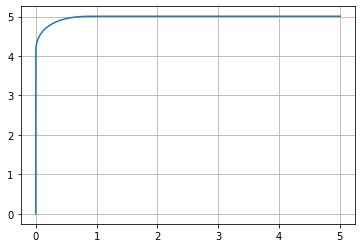

In [159]:
plt.plot(x,y) 
plt.grid()

# More complex example
Borrow the Grid world code from week 2 notebook. Get the A* path and smoothen it using the routine from above

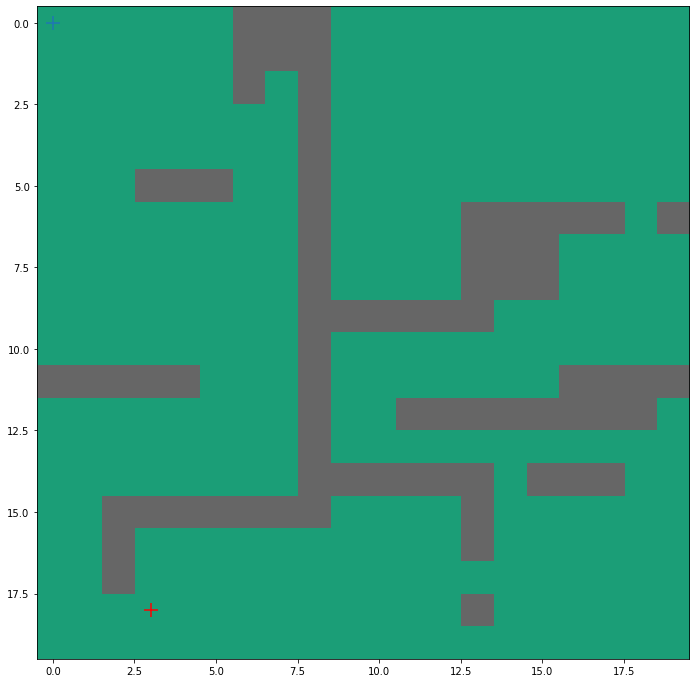

In [160]:
#Viusalise the grid with start and end pose
grid = np.load("astar_grid.npy")
start=(0,0)
goal=(18,3)
fig, ax = plt.subplots(figsize=(12,12))
ax.imshow(grid, cmap=plt.cm.Dark2)
ax.scatter(start[1],start[0], marker = "+",s=200)
ax.scatter(goal[1],goal[0], marker = "+", color = "red", s = 200)
plt.show()



[(0, 0), (1, 0), (2, 0), (3, 0), (4, 0), (5, 0), (6, 0), (7, 0), (8, 0), (9, 0), (10, 0), (10, 1), (10, 2), (10, 3), (10, 4), (10, 5), (11, 5), (12, 5), (13, 5), (14, 5), (14, 4), (14, 3), (14, 2), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (18, 2), (18, 3)]
30


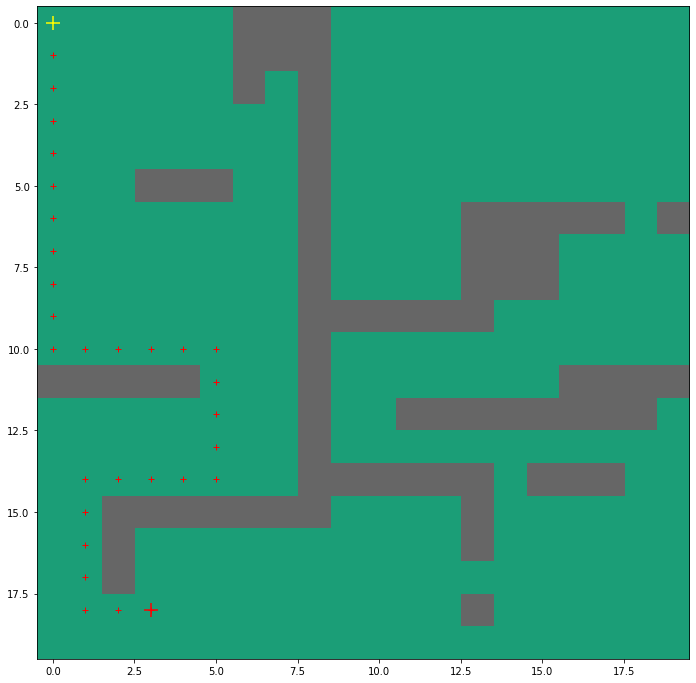

In [161]:
#initialize graph
dim=grid.shape
G=nx.grid_2d_graph(dim[0],dim[1])

#nested loop to remove nodes that are not connected
#free cell => grid[i, j] = ?
#occupied cell => grid[i, j] = ?
for i in range(0,dim[0]):
  for j in range(0,dim[1]):
    if grid[i,j]==1:
      G.remove_node((i,j))

#set the edge_attributes and get the astar path
nx.set_edge_attributes(G,1, name="weight")
G.edges.data()
astar_path =nx.astar_path(G, start, goal, heuristic=euclidean, weight='weight')
print(astar_path)
#visualise the path
fig, ax = plt.subplots(figsize=(12,12))
ax.imshow(grid, cmap=plt.cm.Dark2)
ax.scatter(start[1],start[0], marker = "+", color = "yellow", s = 200)
ax.scatter(goal[1],goal[0], marker = "+", color = "red", s = 200)
for s in astar_path[1:]:
  ax.plot(s[1], s[0],'r+')
print(len(astar_path))


In [166]:
class Astar_smooth:
  def __init__(self,initial_pose,astar_path):
    self.init_pose=initial_pose
    self.astar_path=astar_path
    self.x,self.y,self.t=np.array([]),np.array([]),np.array([])
    self.x=np.append(self.x,initial_pose[0])
    self.y=np.append(self.y,initial_pose[1])
    self.t=np.append(self.t,initial_pose[2])
    self.turn_radius=1 #This class only implemets turn_radius of one
  def corner_points(self):
    corner_point=[]
    for p1,p2,p3 in zip(self.astar_path[:-2],self.astar_path[1:-1],self.astar_path[2:]):
      x1,y1,x2,y2,x3,y3=p1[0],p1[1],p2[0],p2[1],p3[0],p3[1]
      cond=(x1-x2)*(y3-y2)-(x3-x2)*(y2-y1)
      if cond!=0:
        corner_point.append((x2,y2))
    return corner_point
  def smooth(self):
    corner_point=self.corner_points()
    i=0;
    curr_pose=self.init_pose
    print(len(self.astar_path))
    while i<len(self.astar_path)-1:
      if (self.astar_path[i+1] in corner_point):
        p1=self.astar_path[i]
        p2=self.astar_path[i+1]
        p3=self.astar_path[i+2]
        route=segment_to_route(p1,p3,p2,self.turn_radius)
        #print(route)
        px,py,pt=generate_trajectory(route,curr_pose)
        i=i+2
      else:
        p1=self.astar_path[i]
        p2=self.astar_path[i+1]
        dist=euclidean(p1,p2)
        px,py,pt=straight(dist,curr_pose)
        i=i+1
      self.x=np.concatenate([self.x,px])
      self.y=np.concatenate([self.y,py])
      self.t=np.concatenate([self.t,pt])
      curr_pose=[self.x[-1],self.y[-1],self.t[-1]]
    return self.x,self.y,self.t

    

In [170]:
#start=0,0
#goal=18,3
initial_pose=(0,0,0)
a=Astar_smooth(initial_pose,astar_path)
x,y,t=a.smooth()
len(x)

30


6004

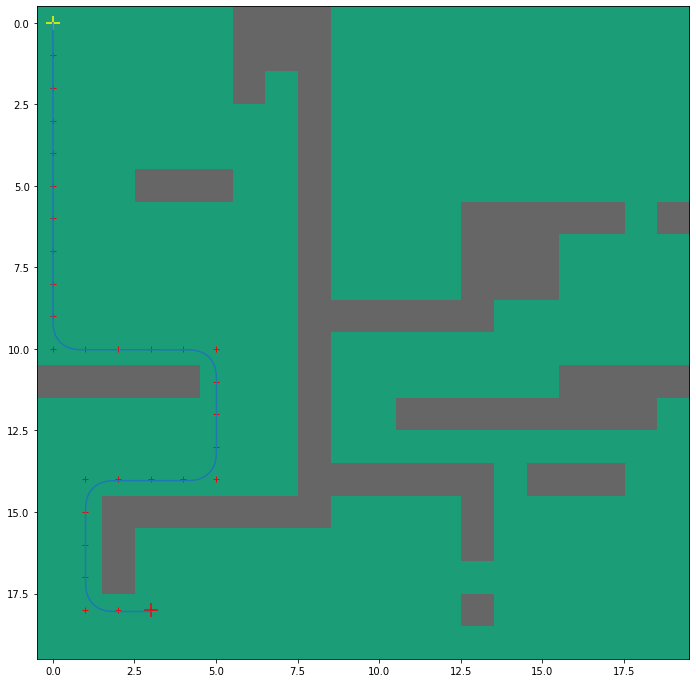

In [171]:
#visualise the path
fig, ax = plt.subplots(figsize=(12,12))
ax.imshow(grid, cmap=plt.cm.Dark2)
ax.scatter(start[1],start[0], marker = "+", color = "yellow", s = 200)
ax.scatter(goal[1],goal[0], marker = "+", color = "red", s = 200)
for s in astar_path[1:]:
  ax.plot(s[1], s[0],'r+')
ax.plot(y,x)


This approach of path planning with 90 deg turns juxtaposed between straight segments works well in structured environments.

In the general case, where $A^*$/ $RRT^*$ path is a sequence of piecewise linear segments, we will perform a path optimization routine directly. 

There are 3 more advanced manouevres that you may need

1. Lane-change: Robot has to move laterally but without change to the orientation

2. Inplace: Robot has to turn around itself
    
3. Reverse: Straights or turns in reverse

Lane-change has to be applied as a combination of 2 cubic spirals (90 to 0 and 0 to 90). Inplace and Reverse are situational constructs